# Time Series Feature Extraction Library

GitHub - https://github.com/fraunhoferportugal/tsfel

Docs - https://tsfel.readthedocs.io/en/latest/

In [1]:
import sys
sys.path.append(
    "/Users/dmitrys/Desktop/DataProjects/otus-advanced-ml/Materials/13-ts-feature-extraction/"
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tsfel

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interpolate
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
from src.utils import *

In [4]:
INPUT_FOLDER_TRAIN = '../data/raw/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = '../data/raw/UCI_HAR/test/InertialSignals/'

LABELFILE_TRAIN = '../data/raw/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = '../data/raw/UCI_HAR/test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

In [5]:
# dataset sampling frequency
fs = 100

In [6]:
cfg_file = tsfel.get_features_by_domain('temporal')

In [7]:
cfg_file

{'temporal': {'Absolute energy': {'complexity': 'log',
   'description': 'Computes the absolute energy of the signal.',
   'function': 'tsfel.abs_energy',
   'parameters': '',
   'use': 'yes'},
  'Area under the curve': {'complexity': 'log',
   'description': 'Computes the area under the curve of the signal computed with trapezoid rule.',
   'function': 'tsfel.auc',
   'parameters': {'fs': 100},
   'use': 'yes'},
  'Autocorrelation': {'complexity': 'constant',
   'description': 'Computes autocorrelation of the signal.',
   'function': 'tsfel.autocorr',
   'parameters': '',
   'use': 'yes'},
  'Centroid': {'complexity': 'constant',
   'description': 'Computes the centroid along the time axis.',
   'function': 'tsfel.calc_centroid',
   'parameters': {'fs': 100},
   'use': 'yes'},
  'Entropy': {'complexity': 'log',
   'description': 'Computes the entropy of the signal using the Shannon Entropy.',
   'function': 'tsfel.entropy',
   'parameters': {'prob': 'standard'},
   'use': 'yes'},
  'M

In [8]:
train_signals.shape

(7352, 128, 9)

In [9]:
EXTRACT = True

if EXTRACT:
    X_train = tsfel.time_series_features_extractor(cfg_file, train_signals, fs=fs)
    X_test = tsfel.time_series_features_extractor(cfg_file, test_signals, fs=fs)
    X_train.to_csv('../data/processed/X_train_tsfel.csv')
    X_test.to_csv('../data/processed/X_test_tsfel.csv')
else:
    X_train = pd.read_csv('../data/processed/X_train_tsfel.csv', index_col=0)
    X_test = pd.read_csv('../data/processed/X_test_tsfel.csv', index_col=0)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [10]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

In [11]:
Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

In [12]:
X_train.shape, X_test.shape

((7352, 87), (2947, 87))

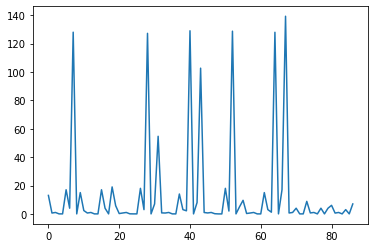

In [13]:
plt.plot(X_train[0])

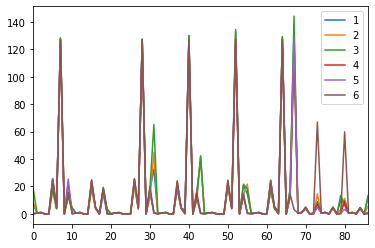

In [14]:
pd.DataFrame(X_train).groupby(pd.Series(Y_train)).mean().T.plot()

In [15]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.9131319986426875
              precision    recall  f1-score   support

           1       0.92      0.94      0.93       496
           2       0.87      0.96      0.91       471
           3       0.93      0.80      0.86       420
           4       0.91      0.83      0.87       491
           5       0.86      0.92      0.89       532
           6       1.00      1.00      1.00       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



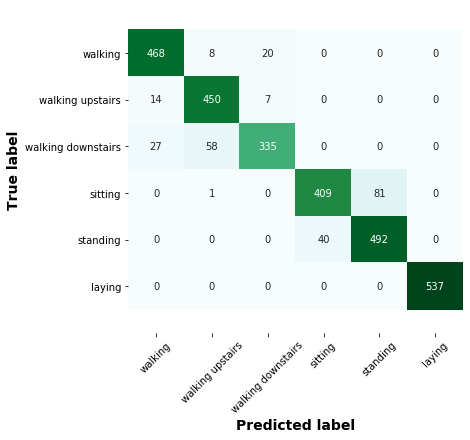

In [16]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}   
plot_confusion(Y_test, Y_test_pred, activities_description.values())